## Face Recognition (from Python Data Science Handbook by Jake VanderPlas)

As an example of support vector machines in action, let's take a look at the facial recognition problem.
We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures.
A fetcher for the dataset is built into Scikit-Learn:

In [1]:
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Let's plot a few of these faces to see what we're working with:

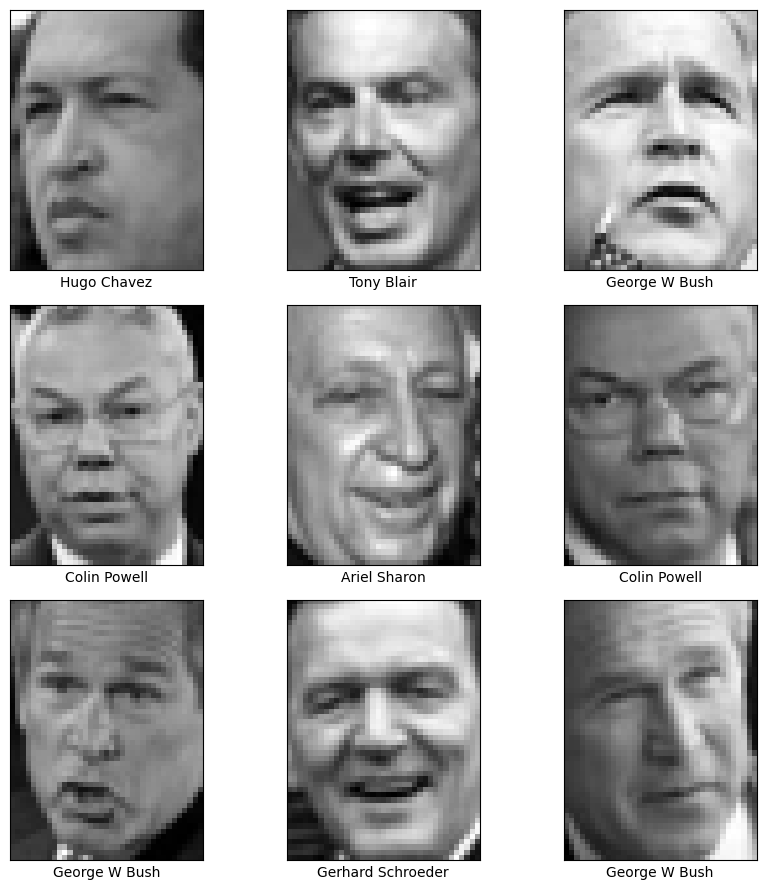

In [2]:
import matplotlib.pyplot as plt
from sklearn import datasets

# Load the LFW dataset
lfw = datasets.fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# Plot a few sample faces from the dataset
fig, axes = plt.subplots(3, 3, figsize=(9, 9))

# Loop through the axes and plot images
for i, ax in enumerate(axes.flat):
    ax.imshow(lfw.images[i], cmap='gray')  # Display image in grayscale
    ax.set(xticks=[], yticks=[], xlabel=lfw.target_names[lfw.target[i]])  # Remove axes and label with the person's name

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

Each image contains [62×47] or nearly 3,000 pixels.
We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful features; here we will use a principal component analysis (we will learn about PCA later) to extract 150 fundamental components to feed into our support vector machine classifier.
We can do this most straightforwardly by packaging the preprocessor and the classifier into a single pipeline:

In [ ]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, whiten=True, random_state=42)

For the sake of testing our classifier output, we will split the data into a training and testing set:

In [3]:
from sklearn.model_selection import train_test_split

# Load the LFW dataset
lfw = datasets.fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# Features (flattened image data)
X = lfw.data

# Labels (person names corresponding to each image)
y = lfw.target

# Split the data into training and testing sets (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Verify the shape of the splits
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)


Training data shape: (966, 1850)
Test data shape: (322, 1850)


Finally, we can use a grid search cross-validation to explore combinations of parameters.
Here we will adjust ``C`` (which controls the margin hardness) and ``gamma`` (which controls the size of the radial basis function kernel), and determine the best model:

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Create the parameter grid for C and gamma
param_grid = {
    'svc__C': [0.1, 1, 10, 100],  # Regularization parameter
    'svc__gamma': [0.001, 0.01, 0.1, 1]  # Kernel coefficient
}

# Create a pipeline with StandardScaler, PCA, and SVM with RBF kernel
pipeline = make_pipeline(
    StandardScaler(),  # Standardize the data
    PCA(n_components=150, whiten=True),  # Apply PCA for dimensionality reduction
    SVC(kernel='rbf')  # Use RBF kernel for SVM
)

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the model to find the best parameters
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation Score: {:.4f}".format(grid_search.best_score_))

# Evaluate on the test set with the best model
y_pred = grid_search.predict(X_test)
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=lfw.target_names))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'svc__C': 10, 'svc__gamma': 0.001}
Best Cross-validation Score: 0.8219
Classification Report:
                    precision    recall  f1-score   support

     Ariel Sharon       0.60      0.69      0.64        13
     Colin Powell       0.75      0.83      0.79        60
  Donald Rumsfeld       0.78      0.78      0.78        27
    George W Bush       0.89      0.92      0.91       146
Gerhard Schroeder       0.95      0.76      0.84        25
      Hugo Chavez       0.77      0.67      0.71        15
       Tony Blair       0.93      0.78      0.85        36

         accuracy                           0.84       322
        macro avg       0.81      0.78      0.79       322
     weighted avg       0.85      0.84      0.84       322



The optimal values fall toward the middle of our grid; if they fell at the edges, we would want to expand the grid to make sure we have found the true optimum.

Now with this cross-validated model, we can predict the labels for the test data, which the model has not yet seen:

In [5]:
# Predict the labels for the test set using the best model
y_pred = grid_search.predict(X_test)

# Import necessary metrics
from sklearn.metrics import classification_report, accuracy_score

# Print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=lfw.target_names))

# Print the accuracy score
print("Accuracy on Test Data: {:.4f}".format(accuracy_score(y_test, y_pred)))


Classification Report:
                    precision    recall  f1-score   support

     Ariel Sharon       0.60      0.69      0.64        13
     Colin Powell       0.75      0.83      0.79        60
  Donald Rumsfeld       0.78      0.78      0.78        27
    George W Bush       0.89      0.92      0.91       146
Gerhard Schroeder       0.95      0.76      0.84        25
      Hugo Chavez       0.77      0.67      0.71        15
       Tony Blair       0.93      0.78      0.85        36

         accuracy                           0.84       322
        macro avg       0.81      0.78      0.79       322
     weighted avg       0.85      0.84      0.84       322

Accuracy on Test Data: 0.8416


Let's take a look at a few of the test images along with their predicted values:

ValueError: cannot reshape array of size 1850 into shape (47,62)

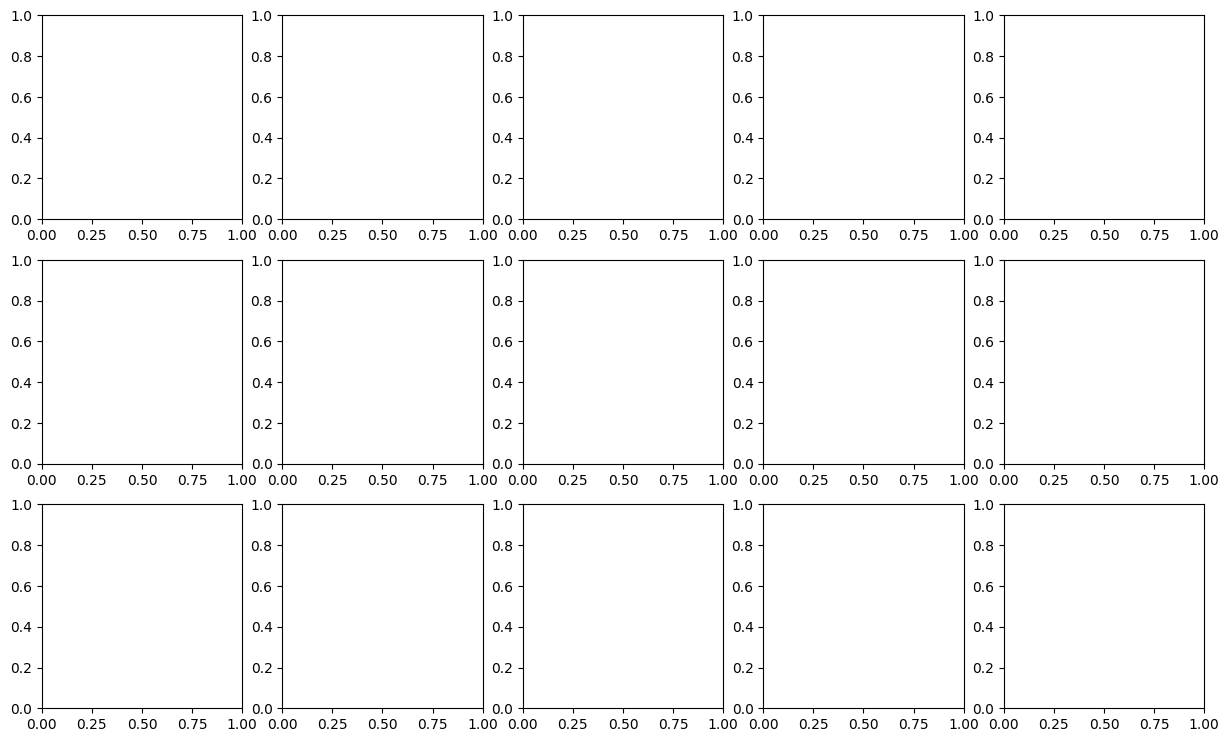

In [7]:
import matplotlib.pyplot as plt

# Let's plot a few test images along with their predicted labels
fig, axes = plt.subplots(3, 5, figsize=(15, 9))  # Create a grid of 3 rows and 5 columns
axes = axes.ravel()  # Flatten the 2D array of axes to make it easier to loop through

# Loop through the first 15 test samples
for i in range(15):
    ax = axes[i]
    ax.imshow(X_test[i].reshape(47, 62), cmap=plt.cm.gray)  # Reshape the 1D image array back to 2D
    ax.set_title(f"Pred: {lfw.target_names[y_pred[i]]}\nTrue: {lfw.target_names[y_test[i]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()


Out of this small sample, our optimal estimator mislabeled only a single face (Bush’s
face in the bottom row was mislabeled as Blair).
We can get a better sense of our estimator's performance using the classification report, which lists recovery statistics label by label:

In [8]:
from sklearn.metrics import classification_report, accuracy_score

# Generate the classification report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=lfw.target_names))

# Calculate and print the overall accuracy score
print("Accuracy on Test Data: {:.4f}".format(accuracy_score(y_test, y_pred)))


Classification Report:
                    precision    recall  f1-score   support

     Ariel Sharon       0.60      0.69      0.64        13
     Colin Powell       0.75      0.83      0.79        60
  Donald Rumsfeld       0.78      0.78      0.78        27
    George W Bush       0.89      0.92      0.91       146
Gerhard Schroeder       0.95      0.76      0.84        25
      Hugo Chavez       0.77      0.67      0.71        15
       Tony Blair       0.93      0.78      0.85        36

         accuracy                           0.84       322
        macro avg       0.81      0.78      0.79       322
     weighted avg       0.85      0.84      0.84       322

Accuracy on Test Data: 0.8416


We might also display the confusion matrix between these classes:

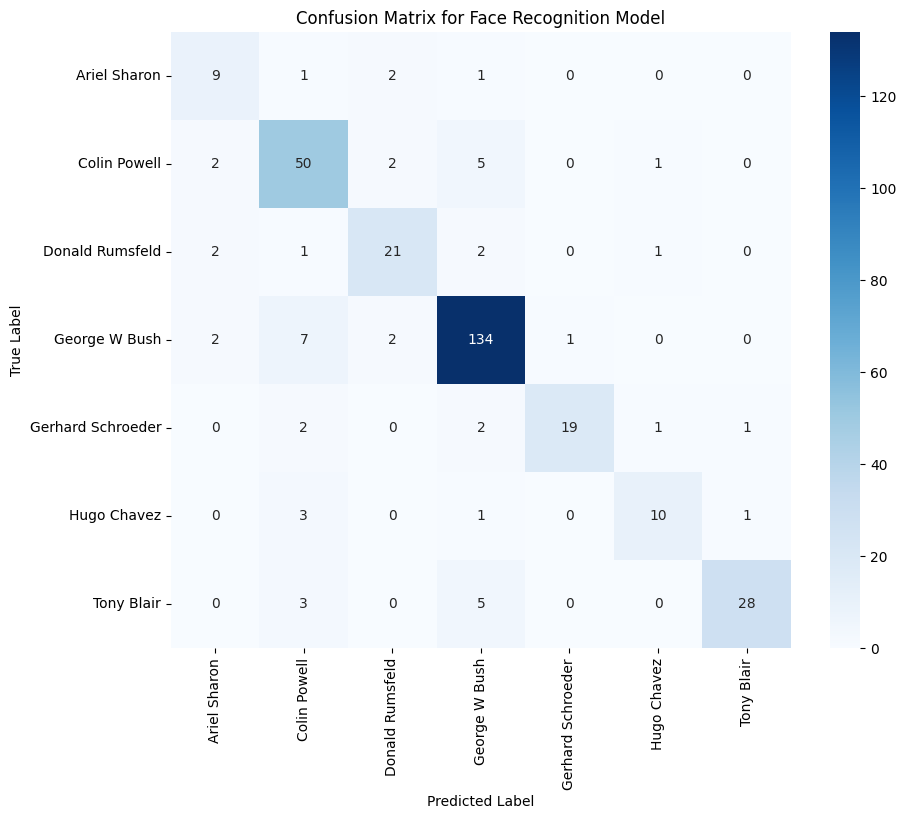

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lfw.target_names, yticklabels=lfw.target_names)
plt.title('Confusion Matrix for Face Recognition Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


This helps us get a sense of which labels are likely to be confused by the estimator.

For a real-world facial recognition task, in which the photos do not come pre-cropped into nice grids, the only difference in the facial classification scheme is the feature selection: you would need to use a more sophisticated algorithm to find the faces, and extract features that are independent of the pixellation.
For this kind of application, one good option is to make use of [OpenCV](http://opencv.org), which, among other things, includes pre-trained implementations of state-of-the-art feature extraction tools for images in general and faces in particular.

In [ ]:
import cv2
import numpy as np

# Load the pre-trained Haar Cascade face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Initialize the LBPH face recognizer (Local Binary Patterns Histogram)
recognizer = cv2.face.LBPHFaceRecognizer_create()

# Load a pre-trained model (for simplicity, let's assume we have one)
recognizer.read('face_trained_model.yml')

# Load an image
image = cv2.imread('image.jpg')

# Convert the image to grayscale (Haar Cascade works on grayscale images)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# For each face, apply the recognizer
for (x, y, w, h) in faces:
    face = gray[y:y+h, x:x+w]
    
    # Recognize the face based on the model
    label, confidence = recognizer.predict(face)
    
    # Draw a rectangle around the face and label the face
    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
    cv2.putText(image, f'Person {label}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

# Display the image with detected faces and labels
cv2.imshow('Detected Faces', image)
cv2.waitKey(0)
cv2.destroyAllWindows()


: 